##  Study on how to give initial data. 

We want to have a very isotropic data with a given frequency, or perhaps a distribution (thermal?) for $phi$ and its time derivative. Here
We do in 2dim.

We first create a distribution of values on Fourier space both for $ϕ $ and its time derivative, $\phi_t$.
I think we need a thermal distribution, that is we fix a temperature and put particles at that temperature.
That is we shall use the $\omega = |k|$ rule, we take positive so as to have particles and not antiparticles.



In [1]:
using Plots
using Distributions
using FFTW
using LinearAlgebra
using Revise
using Base.Threads
#import Pkg; Pkg.add("HDF5")
using HDF5
using SummationByPartsOperators

In [2]:
includet("../PIC/PIC-1D/aux_functions/inidat_aux_functions.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions.jl")
#includet("../PIC-1D/aux_functions/inidat_aux_functions.jl")
#includet("../PIC-1D/aux_functions/aux_functions.jl")
includet("local_aux_functions.jl")

We first look at the scheme for a distribution which resembles a delta function $k$ in Fourier space.
It gives a rather homogeneous distribution is space.

In [3]:
#J = (501,501,501)
#

# We start with a small periodic box with nontrivial data up to the boundary. 
# Latter we can add the space around to make the asymtotic region.
#Box_x = [-220.0, 220.0, -220.0, 220.0, -220.0, 220.0]; J = (440,440,440) #big
#Box_x = [-120.0, 120.0, -120.0, 120.0, -120.0, 120.0]; J = (240,240,240) #medium
#Box_x = [-55.0, 55.0, -55.0, 55.0, -55.0, 55.0]; J = (110,110,110) #small
Box_x = [-25.0, 25.0, -25.0, 25.0, -25.0, 25.0]; J = (50,50,50) #tiny

dx = differentials(Box_x,J)
κ = 2π./(Box_x[2:2:end] - Box_x[1:2:end-1])
V = volume(Box_x)
ϕ = Array{ComplexF64}(undef,J...)
ϕ_t = copy(ϕ)
#g = copy(ϕ)
#g_t = copy(ϕ)
#g_p = copy(ϕ)

m = 1
m2 = m^2

N = 1000 #number of particles
 
# k0= 500; δ = 1000 # para J=2001
k0 = 1; δ = 0.5


0.5

In [4]:
dx

3-element Vector{Float64}:
 1.0
 1.0
 1.0

In [5]:
k0 = 1.2 #1.0 #1.2; 
δ = 0.5 #coarse k0=0.5
bola_pars = (k0, δ) #second parameter not used (this is a ball unit of radius k0)
capa_pars = (k0, δ) #this is a crost of radius k0 and width 
#g, g_t, g_p = get_fourier_data(capa,Box_x,J,1,capa_pars)
g, g_t, g_p = get_fourier_data(bola,Box_x,J,1,bola_pars)

(ComplexF64[-0.7144301002394031 - 0.29076714032509193im -0.7610577819571055 - 0.10537685157252431im … 0.7555457135431587 + 0.07849845657554878im 0.15682638476219338 + 0.7521427479988274im; 0.034331797493782734 - 0.7675510119892053im -0.6760590448371503 - 0.3587781250603423im … 0.7565996445248266 + 0.018172602112718837im -0.3909732261206751 - 0.6579646735081801im; … ; -0.7596013717186938 + 0.004133886943643683im -0.06940852382680573 + 0.7536283715352182im … -0.4672003757591727 - 0.5850829836336401im -0.5785008426044229 + 0.4879652043625794im; -0.5420897019400631 + 0.5444740428848198im 0.5061744323167678 + 0.5740775376172912im … 0.6959916512867684 - 0.2972690480049322im 0.16640440338784004 - 0.7470523071787354im;;; 0.24387524190700238 - 0.7285863673646441im -0.7284142603634102 + 0.23492603182099797im … -0.13066768521419206 - 0.7454523603848915im -0.7376157951275782 - 0.20420703686759936im; 0.7440628065265664 + 0.17929895446361052im -0.4442559951869089 + 0.6196624081095794im … 0.302803888

sum(abs.(g)) * prod(κ) = 4.929197059340181


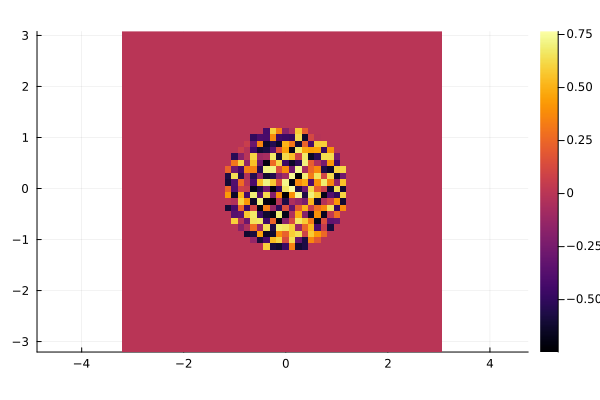

In [6]:

@show sum(abs.(g))*prod(κ)
kx, ky, kz = get_frequencies(Box_x,J)
kx_p = sort(kx)
ky_p = sort(ky)
kz_p = sort(kz)
heatmap(ky_p,kx_p,real.(g_p[:,:,J[3]÷2]), aspectratio = 1)
#surface(ky_p,kx_p,real.(g[:,:]), aspectratio = 1)


In [7]:
#ifft(g,J...)
p_i = plan_ifft(g; flags=FFTW.ESTIMATE, timelimit=Inf);

In [8]:
ϕ = p_i*g*sqrt(prod(J));
ϕ_t = p_i*g_t*sqrt(prod(J));


In [9]:

sum(ϕ.*conj.(ϕ))/prod(J)

0.013228713256571585 + 0.0im

In [10]:

@show norm(ϕ)
@show mean(ϕ)
@show var(ϕ);
@show n(ϕ,ϕ_t,Box_x,J);

norm(ϕ) = 40.664347493491746
mean(ϕ) = -0.0020207134742522667 - 0.0008224136666803713im
var(ϕ) = 0.013224059401862633
n(ϕ, ϕ_t, Box_x, J) = (2709.5924504051527, 0.02167673960324122)


In [11]:
p = 4 #polinomial order
percent = 0.550 #0.6 goes up to the border in poli_cut use 0.550 for step_cut
δ = 0.3 #less than 1!
x,y,z = get_coords(Box_x,J)
#ϕ_h_cut = polinomial_cut(ϕ,Box_x,J,p,percent);
#ϕ_h_step_cut = step_cut(ϕ,Box_x,J,p,percent,δ);
#heatmap(x,y,real.(ϕ_h_step_cut[:,:,J[3]÷2]), aspectratio=1)
#heatmap(real.(ϕ_h_cut[J[1]÷2,:,:]), aspectratio=1)
#heatmap(real.(ϕ_h_cut[:,J[2]÷2,:]), aspectratio=1)
#heatmap(imag.(ϕ[:,J[2]÷2,:]), aspectratio=1)
#surface(x,y,real.(ϕ_h_step_cut[:,:,J[3]÷2]), aspectratio=1)
#png("h_cut.png")

([-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16.0  …  15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0], [-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16.0  …  15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0], [-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16.0  …  15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0])

In [12]:
#ϕ_h_cut = polinomial_cut(ϕ,Box_x,J,8);
#ϕ_t_h_cut = polinomial_cut(ϕ_t,Box_x,J,8);

ϕ_h_cut = step_cut(ϕ,Box_x,J,p,percent,δ)
ϕ_t_h_cut = step_cut(ϕ_t,Box_x,J,p,percent,δ);


In [13]:
(π2,∇2,V) = get_rho(ϕ_h_cut,ϕ_t_h_cut,Box_x,J);

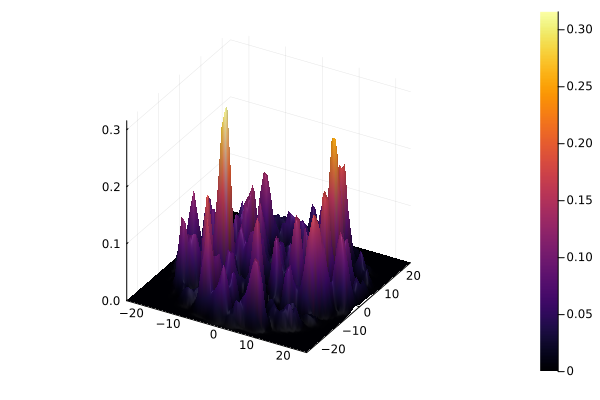

In [14]:
surface(x,y,π2[:,:,J[3]÷2])

In [21]:
#= with true we add here the external region, this can also be done using the cut function with a
differnt percentage value. If used then have to substitute below J by J_out and Box_x by Box_x_out
=# 
if false 
    
enlarge_factor = 2 # or 3
if enlarge_factor == 3 
    @show J_out = (3).*J
    @show Box_x_out = 3*Box_x;
elseif enlarge_factor == 2
    @show J_out = J .+ (2).*((J.÷2).+1)
    @show Box_x_out = [Box_x[1] - dx[1]*(J_in[1]÷2 +1),Box_x[2] + dx[1]*(J[1]÷2 +1)   , Box_x[3] - dx[2]*(J[2]÷2 +1), Box_x[4] + dx[2]*(J[2]÷2 +1) , Box_x[5] - dx[3]*(J[3]÷2 +1), Box_x[6] + dx[3]*(J[3]÷2 +1)];
end

π2 = embed_source(π2,J_out, enlarge_factor);
#heatmap(x,y,π2[:,:,J_out[3]÷2], aspectratio=1)
∇2 = embed_source(∇2,J_out, enlarge_factor);
#heatmap(x,y,∇2[:,:,J_out[3]÷2], aspectratio=1)
V = embed_source(V,J_out, enlarge_factor);
heatmap(x,y,V[:,:,J_out[3]÷2], aspectratio=1)
end



In [15]:

N_fields = 7 #Int32(1)

x, y, z = get_coords(Box_x,J)

#= this data has already an extra point added so as to be symmetric. That is in each dimension we
add an extra point and put there the data from the other extreme. 
=#

#file_name = "data_3d_h_step_cut_medium_capa"
#file_name = "data_3d_h_step_cut_small_bola"
file_name = "data_3d_step_cut_tiny_bola"
load_data_full_h5("Inidats/" * file_name, Box_x,J,ϕ_h_cut,ϕ_t_h_cut,N_fields)
# Open an HDF5 file in write mode


In [ ]:
data = h5open("data_3d_h_step_cut_small.h5", "r")

In [ ]:
var0 = read(data["var0"])
heatmap(x,y,var0[:,:,J[3]÷2], aspectratio=1)
#heatmap(x,y,real.(ϕ_h_cut)[:,:,J[3]÷2], aspectratio=1)

## Thermal distribution

We use a relativistic thermal distribution. I guess we are setting the mass to 1 but I don't know the temperature.



In [ ]:
θ = 1.0
m = 1.0
m2 = m^2
norm_rel = 2.0
p_max = 10*θ
Box_p =(-p_max,p_max,-p_max,p_max,-p_max,p_max)
#dp = differentials(Box_p,J)
L = zeros(J...)
L = Box_p[2:2:end] .- Box_p[1:2:end]
f_p = f_p_rel 
f_p_max = f_p_rel_max
par_f_p_1 = (θ,norm_rel,2)
#norm_rel = int_mid_point_f(f_p, par_f_p_1, [20_000,20_000], Box_p)
par_f_p = (θ, norm_rel,2)
interval_p = Box_p


In [ ]:
g_th = fill(0.0+im*0.0,J...)
gt_th = fill(0.0+im*0.0,J...)

N=100000
plt = Plots.scatter(labels=false)
for i in 1:N÷2
    kr = random_sampling_from_distribution_D(f_p,f_p_max,par_f_p,interval_p)
    j = get_index_p(kr,J,L)
    jm = get_index_p(-kr,J,L)
    if (abs(j[1]) > J[1] || abs(jm[1])) > J[1] || (abs(j[2]) > J[2] || abs(jm[2])) > J[2]
        println("j = $j, jm = $jm, kr = $kr")
    end
    #Plots.scatter!(plt,[j[1],jm[1]],[j[2],jm[2]],label=false)
    factor = 1.0/sqrt(2*ω([kr[1],kr[2],kr[3]],m2))
    phase_p = exp(im*rand()*2*π)
    phase_m = exp(im*rand()*2*π)
    g_th[j...] += phase_p*factor
    g_th[jm...] += phase_m*factor
    gt_th[j...] += im*phase_p/factor/2.0
    gt_th[jm...] += 2.0*im*phase_m/factor/2.0
end

#heatmap(real.(g_th))
surface(real.(g_th[30,:,:]))
#plt

In [37]:
ϕ_th = p_i*g_th*sqrt(prod(J));
ϕt_th = p_i*gt_th*sqrt(prod(J));

In [ ]:
#heatmap(imag.(ϕ_th))
surface(imag.(ϕ_th[30,:,:]))

In [ ]:
#@show sum(ϕ.*conj.(ϕ))*prod(dx)/V

n(ϕ_th,ϕt_th,Box_x,J)

### Localization



In [41]:
#ϕ_th_cut = polinomial_cut(ϕ_th,Box_x,J,8);
#ϕ_th_step_cut = poli_step
p = 4 #polinomial order
percent = 0.550 #0.6 goes up to the border in poli_cut use 0.550 for step_cut
δ = 0.3 #less than 1!
#x,y,z = get_coords(Box_x,J)

ϕ_th_step_cut = step_cut(ϕ_th,Box_x,J,p,percent,δ)
ϕ_t_th_step_cut = step_cut(ϕt_th,Box_x,J,p,percent,δ);

In [ ]:
surface(real.(ϕ_th_step_cut[101,:,:]) )

### Data transfer

In [43]:
N_fields = 7 #Int32(1)

x, y, z = get_coords(Box_x,J)

#= this data has already an extra point added so as to be symmetric. That is in each dimension we
add an extra point and put there the data from the other extreme. 
=#
load_data_full_h5("Inidats/data_3d_h_step_cut_medium_thermal",Box_x,J,ϕ_h_cut,ϕ_t_h_cut,N_fields)
# Open an HDF5 file in write mode

In [ ]:
#outdated
if false
N_fields = 4.0 #Int32(1)

x, y, z = get_coords(Box_x,J)

# Open an HDF5 file in write mode
h5file = h5open("example_data_3d_gaussian.h5", "w") do file
    write(file, "coord0", x)
    write(file, "coord1", y)
    write(file, "coord2", z)
    write(file, "nvars", [N_fields])
    write(file, "var0", real.(ϕ))
    write(file, "var1", imag.(ϕ))
    write(file, "var2", real.(ϕ_t))
    write(file, "var3", imag.(ϕ_t))
end
end